In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def fitting(p0,x,y1,y2):

    pKa1, pKa2, w = p0

    Z = 1 + 10**(pKa1-x) + 10**(pKa2-x) + 10**(pKa1+pKa2-w-2*x)
    f1 = 1/Z +  10**(pKa1-x)/Z
    f2 = 1/Z +  10**(pKa2-x)/Z
    
    diff1 = np.sum(np.absolute(f1-y1))
    diff2 = np.sum(np.absolute(f2-y2))
        
    return diff1 + diff2


# for resolving protonation probabilities as a function of pKa
def partition(pKa1,pKa2,w=0,ph=np.arange(-14,14,0.01)):
    
    Z = 1 + 10**(pKa1-ph) + 10**(pKa2-ph) + 10**(pKa1+pKa2-w-2*ph)
    
    return 1/Z, 10**(pKa1-ph)/Z, 10**(pKa2-ph)/Z, 10**(pKa1+pKa2-w-2*ph)/Z

# compute macroscopic pK from microscopic
def macro(pk1,pk2,w):
    pka1 = pk1
    pka2 = pk2
    w    = w
    
    Ka1 = 10**(-pka1)
    Ka2 = 10**(-pka2)
    
    Ka1a = 10**(-(pka1-w))
    Ka2a = 10**(-(pka2-w))
    return -np.log10((Ka1*Ka2)/(Ka1+Ka2)), -np.log10(Ka1a+Ka2a)



pka1: 5.52 pka2: 3.42


Text(0.5, 0, 'pH')

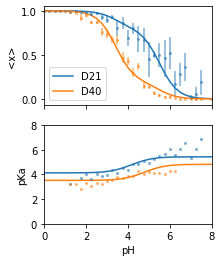

In [2]:
fig,axs = plt.subplots(2,1,figsize=(3,4),sharex=True)

ph,mu1,sg1,mu2,sg2 = np.loadtxt("./cphmd/D21-D40.dat",comments=["#"]).T

# plot protonation probability traces
axs.flat[0].errorbar(x=ph,y=1-mu1,yerr=sg1,fmt='o',mew=0,ms=3,alpha=0.6,color='tab:blue')
axs.flat[0].errorbar(x=ph,y=1-mu2,yerr=sg2,fmt='o',mew=0,ms=3,alpha=0.6,color='tab:orange')

with np.errstate(divide='ignore'):
    axs.flat[1].errorbar(x=ph,y=ph-np.log10(np.divide(mu1,(1-mu1),where=(1-mu1)!=0)),
                                            fmt='o',mew=0,ms=3,alpha=0.6,color='tab:blue')
                         
    axs.flat[1].errorbar(x=ph,y=ph-np.log10(np.divide(mu2,(1-mu2),where=(1-mu2)!=0)),
                                            fmt='o',mew=0,ms=3,alpha=0.6,color='tab:orange')


# resample points assuming gaussians
s1 = np.random.normal(mu1, sg1, size=(100, mu1.shape[0]))
s2 = np.random.normal(mu2, sg2, size=(100, mu2.shape[0]))

vals = []
# perform fitting off the Hill/Ullmann formalism
for pair in zip(s1,s2):

    y1 = pair[0]
    y2 = pair[1]
    res = minimize(fitting, x0=[3,5,1], bounds=[(0,14),(0,14),(0,5.)],args=(ph,y1,y2)) #,method='Nelder-Mead')
    
    vals.append(res.x)

# get average fitted microscopic pKas
a,b,c,d = partition(*np.nanmean(vals,axis=0),ph=ph)

pk1,pk2 = macro(*np.array([np.nanmean(vals,axis=0),np.nanstd(vals,axis=0)]).T)
print("pka1: %.2f pka2: %.2f" % (pk1[0],pk2[0]))

axs.flat[0].plot(ph,1-(b+a),color='tab:blue',label="D21")
axs.flat[0].plot(ph,1-(c+a),color='tab:orange',label="D40")

axs.flat[1].plot(ph,ph-np.log10((b+a)/(1-(b+a))),color='tab:blue')
axs.flat[1].plot(ph,ph-np.log10((c+a)/(1-(c+a))),color='tab:orange')

axs.flat[0].legend(loc='lower left')
axs.flat[0].set_xlim(0,8)
axs.flat[1].set_ylim(0,8)
axs.flat[0].set_ylabel("<x>")
axs.flat[1].set_ylabel("pKa")
axs.flat[1].set_xlabel("pH")